Python実践データ分析100本ノック（秀和システム）の勉強記録を載せています。<br>
問題の解説、コードを載せています。参考になれば幸いです。<br>
わからない点等ございましたらコメントお願いします。¶

## ノック41 : データを読み込んで利用データを整形する

In [1]:
import pandas as pd
customer = pd.read_csv('../input/sport-gym/customer_join.csv')
uselog_months = pd.read_csv('../input/python-100-31-40/use_log_months.csv')
# データの確認
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [2]:
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [3]:
# 当月と一ヶ月前の利用回数を集計したデータを作成する
year_months = list(uselog_months['年月'].unique())
uselog = pd.DataFrame()

for i in range(1, len(year_months)):
    # リストに存在する年月のデータと一致するレコードを取り出す（当月分)
    tmp = uselog_months.loc[uselog_months['年月'] == year_months[i]].copy()
    tmp.rename(columns={'count' : 'count_0'}, inplace=True)
    # 前月分のデータを取り出す
    tmp_before = uselog_months.loc[uselog_months['年月'] == year_months[i-1]].copy()
    # '年月'列が重複しないように削除
    tmp_before.drop('年月', axis=1, inplace=True)
    tmp_before.rename(columns={'count' : 'count_1'}, inplace=True)
    
    # 取り出したデータを結合する
    tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
    uselog = pd.concat([uselog, tmp], ignore_index=True)

uselog.head()

,年月,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


## ノック42 : 退会前月の退会顧客データを作成する

退会申請を未然に防ぐ、という目的から退会付きの一月前の顧客データに注目する。

In [4]:
from dateutil.relativedelta import relativedelta
# やめた顧客だけを抽出
exit_customer = customer.loc[customer['is_deleted'] == 1].copy()
exit_customer['exit_date'] = None
# やめた日をdatetime型に変換
exit_customer['end_date'] = pd.to_datetime(exit_customer['end_date'])

for i in exit_customer.index:
    # 退会した日付を計算する
    exit_customer.loc[i, 'exit_date'] = exit_customer.loc[i, 'end_date'] - relativedelta(months=1)

# 退会した日付をdatetime型に変換
exit_customer['exit_date'] = pd.to_datetime(exit_customer['exit_date'])
exit_customer['年月'] = exit_customer['exit_date'].dt.strftime('%Y%m')

uselog['年月'] = uselog['年月'].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=['customer_id', '年月'], how='left')
print(len(uselog))
exit_uselog.head()

33851


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


退会した顧客の退会前月のデータのみなので欠損値が多く存在する。データが欠損していないものだけ残す。

In [5]:
# 'name'列に欠損値がある場合削除される。
exit_uselog = exit_uselog.dropna(subset=['name'])
# 抽出された欠損値のないデータを確認
print(len(exit_uselog))
print(len(exit_uselog['customer_id'].unique()))

exit_uselog.head()

1104
1104


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,通常,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30


## ノック43 : 継続顧客のデータ作成

In [6]:
# 継続顧客は退会月が存在しないのでどこを取ってきても良い。
conti_customer = customer.loc[customer['is_deleted'] == 0]
conti_uselog = pd.merge(uselog, conti_customer, on=['customer_id'], how='left')
print(len(conti_uselog))
conti_uselog = conti_uselog.dropna(subset=['name'])
print(len(conti_uselog))

33851
27422


退会した人のデータに比べて継続した人のデータが多い。このまま学習させると不均衡なデータになるので、データを削減する。

In [7]:
# 顧客あたり一件の継続データになるように削減する。
# 例えば、2018年5月のAさんのデータ化2018年12月のAさんのデータどちらかを選ぶ、といった具合。

conti_uselog = conti_uselog.sample(frac=1, random_state=0).reset_index(drop=True)
# customer_idが重複しているデータを削除
conti_uselog = conti_uselog.drop_duplicates(subset='customer_id')
print(len(conti_uselog))
conti_uselog.head()

2842


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201806,AS015233,7,7.0,XXXXX,C01,M,2018-05-13,NaN,CA2,...,オールタイム,10500.0,入会費半額,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0
1,201812,AS046594,7,5.0,XXX,C01,M,2018-03-01,NaN,CA1,...,オールタイム,10500.0,通常,7.166667,7.0,10.0,5.0,1.0,2019-04-30,13.0
2,201808,OA769163,6,4.0,XXX,C01,M,2017-05-01,NaN,CA1,...,オールタイム,10500.0,通常,6.083333,6.0,8.0,2.0,1.0,2019-04-30,23.0
3,201805,AS981537,10,6.0,XX,C03,M,2018-02-01,NaN,CA1,...,ナイト,6000.0,通常,6.916667,7.0,10.0,5.0,1.0,2019-04-30,14.0
4,201805,GD065188,6,7.0,XX,C01,M,2017-09-01,NaN,CA1,...,オールタイム,10500.0,通常,6.333333,6.5,9.0,3.0,1.0,2019-04-30,19.0


* 継続顧客のデータと退会顧客のデータを縦に結合する

In [8]:
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True)
print(len(predict_data))
predict_data.head()

3946


/tmp/ipykernel_18/2208580704.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True)


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201806,AS015233,7,7.0,XXXXX,C01,M,2018-05-13,NaT,CA2,...,10500.0,入会費半額,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0,NaT
1,201812,AS046594,7,5.0,XXX,C01,M,2018-03-01,NaT,CA1,...,10500.0,通常,7.166667,7.0,10.0,5.0,1.0,2019-04-30,13.0,NaT
2,201808,OA769163,6,4.0,XXX,C01,M,2017-05-01,NaT,CA1,...,10500.0,通常,6.083333,6.0,8.0,2.0,1.0,2019-04-30,23.0,NaT
3,201805,AS981537,10,6.0,XX,C03,M,2018-02-01,NaT,CA1,...,6000.0,通常,6.916667,7.0,10.0,5.0,1.0,2019-04-30,14.0,NaT
4,201805,GD065188,6,7.0,XX,C01,M,2017-09-01,NaT,CA1,...,10500.0,通常,6.333333,6.5,9.0,3.0,1.0,2019-04-30,19.0,NaT


## ノック44 : 予測する月の在籍期間を作成する

ノック37を参考に作成。

In [9]:
predict_data['period'] = 0
predict_data['now_date'] = pd.to_datetime(predict_data['年月'], format='%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])
for i in range(len(predict_data)):
    delta = relativedelta(predict_data.loc[i, 'now_date'], predict_data.loc[i, 'start_date'])
    predict_data.loc[i, 'period'] = int(delta.years * 12 + delta.months)

predict_data.head()

,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201806,AS015233,7,7.0,XXXXX,C01,M,2018-05-13,NaT,CA2,...,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0,NaT,0,2018-06-01
1,201812,AS046594,7,5.0,XXX,C01,M,2018-03-01,NaT,CA1,...,7.166667,7.0,10.0,5.0,1.0,2019-04-30,13.0,NaT,9,2018-12-01
2,201808,OA769163,6,4.0,XXX,C01,M,2017-05-01,NaT,CA1,...,6.083333,6.0,8.0,2.0,1.0,2019-04-30,23.0,NaT,15,2018-08-01
3,201805,AS981537,10,6.0,XX,C03,M,2018-02-01,NaT,CA1,...,6.916667,7.0,10.0,5.0,1.0,2019-04-30,14.0,NaT,3,2018-05-01
4,201805,GD065188,6,7.0,XX,C01,M,2017-09-01,NaT,CA1,...,6.333333,6.5,9.0,3.0,1.0,2019-04-30,19.0,NaT,8,2018-05-01


## ノック45 : 欠損値を除去する

In [10]:
predict_data.isna().sum()

年月                      0
customer_id             0
count_0                 0
count_1               255
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

end_dateとexit_dateは退会顧客しか値を持っていないので、継続顧客は欠損値になる。<br>count_1が欠損しているデータだけ除く。

In [11]:
predict_data = predict_data.dropna(subset=['count_1'])
predict_data.isna().sum()

年月                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2639
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2639
period                  0
now_date                0
dtype: int64

## ノック46 : 文字列型の変数を処理できるように整形する

入会キャンペーン区分、会員区分、性別などの文字列データのことを「カテゴリカル変数」と呼ぶ。<br>
活用するためには、「フラグ化」を行う必要がある。（「ダミー変数化」）

説明変数は、<br>
一ヶ月前の利用回数count_1、カテゴリー変数のcampaign_name、class_name、gender、定期利用かのフラグであるroutine_flg、在籍期間のperiod。<br>
目的変数は、<br>
退会フラグのis_deleted


In [12]:
#　予測に使用するデータ列のリスト
target_col = ['campaign_name', 'class_name', 'gender', 'count_1', 
              'routine_flg', 'period', 'is_deleted']
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,入会費半額,オールタイム,M,7.0,1.0,0,0.0
1,通常,オールタイム,M,5.0,1.0,9,0.0
2,通常,オールタイム,M,4.0,1.0,15,0.0
3,通常,ナイト,M,6.0,1.0,3,0.0
4,通常,オールタイム,M,7.0,1.0,8,0.0


In [13]:
# ダミー変数の作成
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,campaign_name_通常,class_name_オールタイム,class_name_デイタイム,class_name_ナイト,gender_F,gender_M
0,7.0,1.0,0,0.0,True,False,False,True,False,False,False,True
1,5.0,1.0,9,0.0,False,False,True,True,False,False,False,True
2,4.0,1.0,15,0.0,False,False,True,True,False,False,False,True
3,6.0,1.0,3,0.0,False,False,True,False,False,True,False,True
4,7.0,1.0,8,0.0,False,False,True,True,False,False,False,True


In [14]:
del predict_data['campaign_name_通常']
del predict_data['class_name_ナイト']
del predict_data['gender_M']
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
0,7.0,1.0,0,0.0,True,False,True,False,False
1,5.0,1.0,9,0.0,False,False,True,False,False
2,4.0,1.0,15,0.0,False,False,True,False,False
3,6.0,1.0,3,0.0,False,False,False,False,False
4,7.0,1.0,8,0.0,False,False,True,False,False


## ノック47 : 決定木を用いて退会予測モデルを作成する

In [15]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

exit = predict_data.loc[predict_data['is_deleted'] == 1]
# 退会ずみ顧客データと同数になるようにランダムに継続顧客データをサンプリングする
conti = predict_data.loc[predict_data['is_deleted'] == 0].sample(len(exit), random_state=0)

X = pd.concat([exit, conti], ignore_index=True)
y = X['is_deleted']
X = X.drop('is_deleted', axis=1)

# 学習用データ（75%）と検証用データ（25%）に分割
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

# 学習モデルを決定木に指定
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)

[1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.

In [16]:
# 検証用データと予測したデータを横に繋げて様子を見てみる
results_test = pd.DataFrame({'y_test' : y_test, 'y_pred' : y_test_pred})
results_test.head()

,y_test,y_pred
1091,0.0,1.0
1786,0.0,0.0
1439,0.0,0.0
745,1.0,1.0
820,1.0,0.0


## ノック48 : 予測モデルの評価とモデルのチューニング

まずresults_testデータを集計して正解率を出してみる。両方とも値が一致すれば正解。

In [17]:
correct = len(results_test.loc[results_test['y_test'] == results_test['y_pred']])
all_data_count = len(results_test)
score_test = correct/all_data_count
print(score_test)

0.8916349809885932


この数字を鵜呑みにするのはまだ早い。機械学習では、あくまで「未知のデータへの適合」が求められる。<br>学習用データで予測した精度と評価用データで予測した精度の差が小さいのが理想的。

In [18]:
print('評価用データのスコア : ' + str(model.score(X_test, y_test)))
print('学習用データのスコア : ' + str(model.score(X_train, y_train)))

評価用データのスコア : 0.8916349809885932
学習用データのスコア : 0.9759188846641318


トレーニングデータに過学習していることがわかる。<br>データを増やしたり、変数を見直したり、モデルのパラメータを更新させて理想的なモデルを作成する。

決定木の深さを浅くすることでモデルの簡易化を図る。

In [19]:
# 一回学習させるとX_train, y_train, X_test, y_testは再使用不可。再度分割を行う
X = pd.concat([exit, conti], ignore_index=True)
y = X['is_deleted']
del X['is_deleted']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=42)

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(X_train, y_train)

print('評価用データのスコア : ' + str(model.score(X_test, y_test)))
print('学習用データのスコア : ' + str(model.score(X_train, y_train)))

評価用データのスコア : 0.8992395437262357
学習用データのスコア : 0.9321926489226869


## ノック49 : モデルに寄与している変数を確認する

In [20]:
importance = pd.DataFrame({'feature_names':X.columns, 'coefficient':model.feature_importances_})
importance

,feature_names,coefficient
0,count_1,0.371260
1,routine_flg,0.134060
2,period,0.486667
3,campaign_name_入会費半額,0.000296
4,campaign_name_入会費無料,0.005065
5,class_name_オールタイム,0.002484
6,class_name_デイタイム,0.000167
7,gender_F,0.000000


性別欄の寄与が0%なのは少し意外...

* ### 木構造の可視化

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=df93c7858dc572606ffe46527eaceb3ba4296cdd6fd47869aa8b2d0d92b9d341
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


[Text(0.5340909090909091, 0.9166666666666666, 'period <= 11.5\ngini = 0.5\nsamples = 1578\nvalue = [793, 785]'),
 Text(0.26515151515151514, 0.75, 'count_1 <= 5.5\ngini = 0.39\nsamples = 956\nvalue = [254, 702]'),
 Text(0.12121212121212122, 0.5833333333333334, 'count_1 <= 4.5\ngini = 0.073\nsamples = 606\nvalue = [23, 583]'),
 Text(0.06060606060606061, 0.4166666666666667, 'count_1 <= 3.5\ngini = 0.016\nsamples = 506\nvalue = [4, 502]'),
 Text(0.030303030303030304, 0.25, 'gini = 0.0\nsamples = 363\nvalue = [0, 363]'),
 Text(0.09090909090909091, 0.25, 'campaign_name_入会費半額 <= 0.5\ngini = 0.054\nsamples = 143\nvalue = [4, 139]'),
 Text(0.06060606060606061, 0.08333333333333333, 'gini = 0.02\nsamples = 97\nvalue = [1, 96]'),
 Text(0.12121212121212122, 0.08333333333333333, 'gini = 0.122\nsamples = 46\nvalue = [3, 43]'),
 Text(0.18181818181818182, 0.4166666666666667, 'routine_flg <= 0.5\ngini = 0.308\nsamples = 100\nvalue = [19, 81]'),
 Text(0.15151515151515152, 0.25, 'gini = 0.0\nsamples = 34\

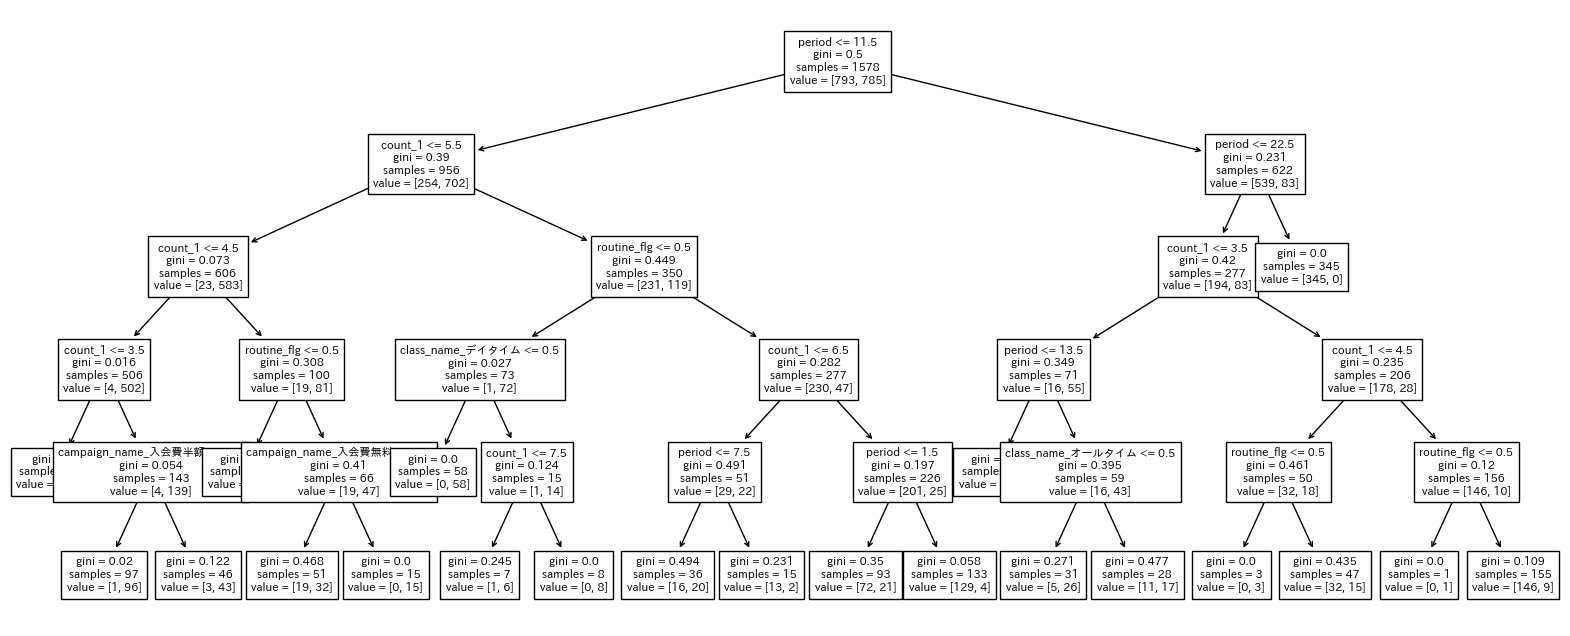

In [21]:
!pip install japanize_matplotlib  # matplotlibを日本語に対応させるためにインストール
from sklearn import tree
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

plt.figure(figsize=(20, 8))
tree.plot_tree(model, feature_names=X.columns, fontsize=8)

どうやって分類されているかの詳細が出る。（SHAP値などが参考になるそう）

参考 : https://qiita.com/ameshikou/items/093d86dd46b4d440deae


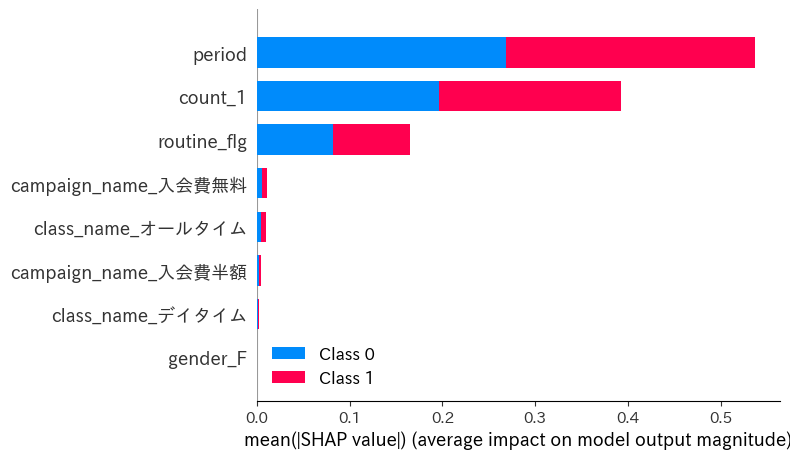

In [22]:
import shap
# jupyter notebookにコードを表示させるためにjsをロード
shap.initjs()

explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X_test)

# SHAP値のプロット（3クラスのbar_plot）
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

各列の内訳ごとにどっちのクラスに分類してるかがわかるみたい。今回の場合だと、どこかの列が特定のクラスに割り振りやすいとかはなさそう。

## ノック50 : 顧客の退会を予測しよう

* #### 予測対象データの作成

いろいろ頑張ってDataFrame型にする

In [23]:
count_1 = 3
routine_flg = 1
period = 10
campaign_name = '入会費無料'
class_name = 'オールタイム'
gender = 'M'

In [24]:
if campaign_name == '入会費半額':
    campaign_name_list = [1, 0]
elif campaign_name == '入会費無料':
    campaign_name_list = [0,1]
elif campaign_name_list == '通常':
    campaign_name = [0,0]

if class_name == 'オールタイム':
    class_name_list = [1,0]
elif class_name == 'デイタイム':
    class_name_list = [0,1]
elif class_name == 'ナイト':
    class_name_list = [0, 0]

if gender == 'F':
    gender_list = [1]
elif gender == 'M':
    gender_list = [0]

In [25]:
input_data = [count_1, routine_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)
input_data = pd.DataFrame(data=[input_data], columns=X.columns)

input_data.head()

,count_1,routine_flg,period,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
0,3,1,10,0,1,1,0,0


In [26]:
print('退会が予測されるか（1だと退会する） : ' + str(model.predict(input_data)[0]))
print('退会しない確率 : ' + str(model.predict_proba(input_data)[0][0]))
print('退会する確率 : ' + str(model.predict_proba(input_data)[0][1]))

退会が予測されるか（1だと退会する） : 1.0
退会しない確率 : 0.0
退会する確率 : 1.0


* この顧客の退会確率は100%らしい！！

### パラメータを変えて遊んでみる

In [27]:
count_1 = 10
routine_flg = 1
period = 10
campaign_name = '入会費無料'
class_name = 'オールタイム'
gender = 'M'

if campaign_name == '入会費半額':
    campaign_name_list = [1, 0]
elif campaign_name == '入会費無料':
    campaign_name_list = [0,1]
elif campaign_name_list == '通常':
    campaign_name = [0,0]

if class_name == 'オールタイム':
    class_name_list = [1,0]
elif class_name == 'デイタイム':
    class_name_list = [0,1]
elif class_name == 'ナイト':
    class_name_list = [0, 0]

if gender == 'F':
    gender_list = [1]
elif gender == 'M':
    gender_list = [0]
    
input_data = [count_1, routine_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)
input_data = pd.DataFrame(data=[input_data], columns=X.columns)

input_data.head()

,count_1,routine_flg,period,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
0,10,1,10,0,1,1,0,0


In [28]:
print('退会が予測されるか（1だと退会する） : ' + str(model.predict(input_data)[0]))
print('退会しない確率 : ' + str(model.predict_proba(input_data)[0][0]))
print('退会する確率 : ' + str(model.predict_proba(input_data)[0][1]))

退会が予測されるか（1だと退会する） : 0.0
退会しない確率 : 0.9699248120300752
退会する確率 : 0.03007518796992481


* #### どうやら前月の利用回数が6回を超えると退会しない確率が非常に高くなるモデルになっているみたい。<br>利用回数が4回では退会確率は低かったのに5回では100%の確率で退会してしまうことになっていたりいろいろ問題はありそう。

### 前半50本お疲れ様でした！！！

## 